# Making A Neural Network From Scratch:

**Goal**: To implement a neural network using only numPy that has two hidden layers and one output layer with two activation functions. We can then train our neural network on the MNIST data-set, and test it to see our accuracy. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chinese-mnist-digit-recognizer/chineseMNIST.csv
/kaggle/input/mnist-digit-recognizer/train.csv


I'm going to first import the mnist digits in csv form, every row represents an image and every column, a pixel, with the first column being the label of the number.

In [2]:
df = pd.read_csv("/kaggle/input/mnist-digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape # rows show how many pictures there are in the csv 

(42000, 785)

We are going to convert this DataFrame into a np.array, and use test_train_split() by sklearn. Then we want to take the **tranpose** of each array so that each array is actually an individual picture (which will be one of the 784 nodes).

In [4]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df.iloc[:, 1:]), np.array(df[['label']]), test_size = .4)
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T 
pixels = df.shape[1] - 1
display(x_train[:, 0].shape, len(x_test[0]), x_train, y_train, y_test) # check configs
# n_xtrain (rows of pixels) = 784, m_xtrain (columns of items) = train/split

(784,)

16800

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

array([[0, 0, 7, ..., 6, 7, 3]])

array([[6, 5, 5, ..., 2, 1, 3]])

Above, we see that y_train is actually an array inside an array, we will fix that below:

In [5]:
y_train, y_test = y_train[0], y_test[0]
y_train, y_test

(array([0, 0, 7, ..., 6, 7, 3]), array([6, 5, 5, ..., 2, 1, 3]))

We also want the RGB values to be scaled from 0-1 so I will divide all training and test X values (the pixels) by 255. Without it some "gradient explosion" will happen. 

In [6]:
x_train, x_test = x_train / 255, x_test / 255
x_train, x_test.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (784, 16800))

**Note**: Basically we want to make the train set an nxm matrix so we can left multiply it by a weight matrix to move from Rm -> R10 (10 is an arbitrary number for the first layer but makes computation easier). This will help to compute a linear combination with the weights and nodes 

# Initialization and Propagation: 
1. creating a random array of weights, W1, W2
2. creating a random array of biases, b1, b2
3. arrays for each layer:
    * input layer
    * first reLU layer (a function applied to each node)
    * second output layer (which will also have a softmax to find a probability distribution of numbers)
4. Make forward and backwards propagation. 

We are also going to start with random weights and biases. Below is a diagram in LaTeX explaining the matrix multiplcation **for a single picture**, where matrix $B$ is our input layer tranposed multiplied by our $A$ matrix, and the biases being added as matrix $C$. The result will be a $10 * m$ matrix, where $m$ is the number of training pictures.





$$\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1,784} \\
a_{21} & a_{22} & \cdots & a_{2,784} \\
\vdots & \vdots & \ddots & \vdots \\
a_{10,1} & a_{10,2} & \cdots & a_{10,784}
\end{bmatrix}
\times
\begin{bmatrix}
b_{11} & b_{12} & \cdots & b_{1m} \\
b_{21} & b_{22} & \cdots & b_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
b_{784,1} & b_{784,2} & \cdots & b_{784,m}
\end{bmatrix}
+
\begin{bmatrix}
c_{11} & c_{12} & \cdots & c_{1m} \\
c_{21} & c_{22} & \cdots & c_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
c_{10,1} & c_{10,2} & \cdots & c_{10,m}
\end{bmatrix}
$$


Here are the softmax function and ReLU function definitions:

$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}
$

where $z_i$ is the i-th element of the input vector z. The softmax function will apply this to each $z_i$.

The softmax function is applied independently to each column of $z$. For a single column (logits for one image), softmax computes that equation.

$
\text{ReLU}(x) = \max(0, x)
$


In [7]:
def init_parameters(): 
    # populate a 10 x 784 matrix with random numbers, W1 is weight for first layer
    W1 = np.random.rand(10, pixels) -0.5
    # continue with biases, which should be a 10x1 vector, which we will broadcast
    # 10x1 -> 10xm so we can add the dot product + b
    b1 = np.random.rand(10, 1) - 0.5
    # second layer weights and biases
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    # we ensure that the weights are centered around 0, instead of 0.5
    # we want some negative weights as well so that is why
    return W1, b1, W2, b2
    
def ReLU(Z): # return the same sized matrix, applied reLU
    return np.maximum(0,Z)
    
def SoftMax(Z): # input: 10 x m matrix
    # for numerical stability, we can add something to catch nan-values
    A = np.exp(Z) / sum(np.exp(Z))
    return A

    # 1. np.exp(Z) applied to every element in Z 
    # 2. np.sum(np.exp(Z)) sums all the values of Z from exp, scalar
    # 3. All elements are normalized, result = 10 x m, for each training result
def forward_propagation(W1, b1, W2, b2, X): # X is the initial input matrix
    # Z1 will be the resulting matrix from matrix multiplication
    Z1 = W1.dot(X) + b1 
    # apply reLU to change from linear combination -> non-linear function
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2 # 10 x m
    A2 = SoftMax(Z2) # predictions
    # return values to update in backpropgation
    return Z1, A1, Z2, A2

## Back Propagation and Updating Weights
We will now be writing the backpropagation part: 
1. We need to write one hot, defined as Y (which is the vector equivalent of what the "actual" value is). This will help determine the cost 
2. Calculate how much each layer contributes to the cost function via partial derivatives:
   * dZ is the error of each of the columns (not the cost). This is written as the partial derivative of the cost with respect to the activation (second layer being soft-max and first layer being ReLU).
   *  dW is the change in cost with respect to the weights. 
   *  dB is the change in cost with respect to the biases.<br>
 For a softmax classifier, we'll use a cross-entropy loss function, which will basically come out to dZ if you take the derivative with respect to activation:

$$J(\hat{y}, y) = -\sum_{i=0}^{c} y_i \log(\hat{y}_i)$$

For the entire math behind what dz is, here is a forum: https://community.deeplearning.ai/t/calculating-gradient-of-softmax-function/1897

Here are the equations if the neural network was linked by one node at a time. z in this case is the the result of the linear combination of the weights + bias not related to "activation" ([3B1B's explanation](https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=3))
:

$\frac{\partial C_0}{\partial w^{(L)}} = \frac{\partial z^{(L)}}{\partial w^{(L)}} \frac{\partial a^{(L)}}{\partial z^{(L)}} \frac{\partial C_0}{\partial a^{(L)}}$

$z^{(L)} = w^{(L)} a^{(L-1)} + b^{(L)}$ <br>
$a^{(L)} = \sigma(z^{(L)})$ <br>
$C^{(0)} = a^{(L)} - y$

Notice how the new layer is based off activation result of the previous layer, this can be also translated into matricies in code you will see below.  

By terrible convention, these names dZ, dB, and dW are equal to the following in 3b1b language: 

$dZ = \frac{\partial C_0}{\partial a^{(L)}}$,
$dB = \frac{\partial C_0}{\partial b^{(L)}}$,
$dW = \frac{\partial C_0}{\partial w^{(L)}}$,


3. Using these equations, we can compute a gradient, which for each layer is a vector that tells us the mangitutde of the effect (cost) of each partial derivative (fancy wording for what we just had above).
   
4. We will then adjust our weights by subtracting each layer's weights by their specific dW, each layer's biases by their dB. We cannot specifically change the previous layer's (L-1) activation, but used it in helping compute each dW and dB. Here's what it will look like:

    $w^{(1)} = w^{(1)} - a * dw^{(1)}$<br>
    $b^{(1)} = b^{(1)} - a * db^{(1)}$<br>
   $w^{(2)} = w^{(2)} - a * dw^{(2)}$<br>
    $b^{(2)} = w^{(2)} - a * db^{(2)}$<br>

This is how gradient descent will work, as dw and db will converge to 0 through **minimizing the cost** with respect to all its partial derivitives. Alpha is the learning rate (a)



* After all these initialization steps, we will be able to run our own neural network by repitition. 

In [8]:
def one_hot(Y): # input: the example labels, output: all the one hot Y's
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) 
    # (#examples, 0-9 *10), we will take transpose later
    
    one_hot_Y[np.arange(Y.size), Y] = 1
    # basically you can put arrays inside index selection in 2d arrays, which is super neat
    # this looks like one_hot_Y[(0 - 784 pixels), (4,5,1,2,4... to m images)]
    return one_hot_Y.T
    
def derivative_ReLU(Z): 
    return Z > 0 # boolean matrix works since True = 1
    
def back_propagation(Z1, A1, Z2, A2, W2, X, Y): # figuring out partial derivatives
    # Z1, Z2 = result of a linear combination of weights + biases
    # A1, A2, = result of activation being called on Z1, Z2
    # X = training input, Y = ouput results
    # reminder that Z1 - A2 are all 10 x m matricies and will broadcast Y.
    m, _ = df.shape # number examples
    
    dZ2 = A2 - one_hot(Y) 
    # dZ2 = partial d of the change in cost in terms of soft-max activation
    # Note this equation is based off of the error because it is the last layer
  
    dW2 = 1/m * dZ2.dot(A1.T)
    # partial d of the second layer costs to weights
    # 1/m is applied to every value and is not part of the p derivative
    # transpose ensures that matrix multiplication exists
   
    dB2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)
    # collapses all rows into 10 x m -> 10 x 1, 
    # partial d of the second layer costs to biases 
    # also has 1/m applied since this matrix is applied to all training examples
    
    dZ1 = W2.T.dot(dZ2) * derivative_ReLU(Z1)
    # the W2.T activation transpose serves to "go backwards" in a sense
    # mathmatical proof will for all calculations will be linked below.

    dW1 = 1/m * dZ1.dot(X.T)
    dB1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)
    # these are actually the same formula as before due to the chain rule !
    return dW1, dB1, dW2, dB2 

def adjust_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha): 
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2   
    return W1, b1, W2, b2

# Training / Testing the Neural Network
We will now be implmeneting the training functionality of the network and test for its accuracy. With gradient descent, the idea is to forward -> backward propagate -> adjust parameters (weights and biases) and then do it again with those new weights and biases. 

[9 9 9 ... 9 9 1] [0 0 7 ... 6 7 3]
Iteration 1 : 0.13456349206349205
[0 9 7 ... 5 9 1] [0 0 7 ... 6 7 3]
Iteration 20 : 0.26976190476190476
[0 0 7 ... 5 9 1] [0 0 7 ... 6 7 3]
Iteration 40 : 0.3840873015873016
[0 3 7 ... 8 9 8] [0 0 7 ... 6 7 3]
Iteration 60 : 0.490952380952381
[0 3 7 ... 8 9 2] [0 0 7 ... 6 7 3]
Iteration 80 : 0.5757539682539683
[0 3 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 100 : 0.6336904761904761
[0 3 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 120 : 0.6753571428571429
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 140 : 0.7032936507936508
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 160 : 0.7276587301587302
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 180 : 0.7442460317460318
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 200 : 0.7594047619047619
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 220 : 0.7701190476190476
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 240 : 0.7803174603174603
[0 0 7 ... 5 9 2] [0 0 7 ... 6 7 3]
Iteration 260 : 0.7884920634920635
[0 0 7 ... 

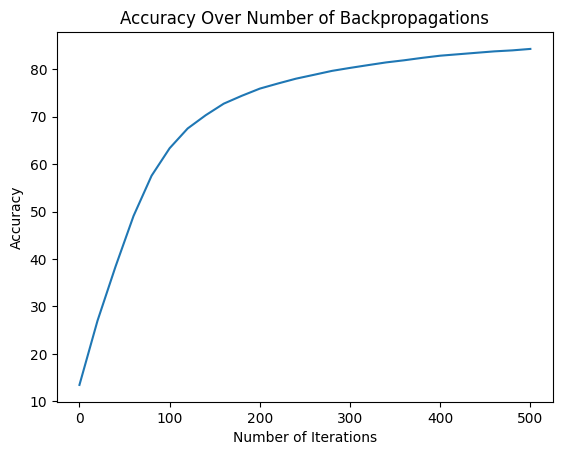

In [9]:
def get_predictions(A2):
    return np.argmax(A2, axis = 0) 
    # argmax for a 10 x m matrix (A2, result of SoftMax)
    # this converts our Softmax probability distribution into predictions
    # using axis 0, we look at the maximum of each column and return the **INDEX**, which is 0 based.
   
def accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size
    # thank you Data 8 for encoding this formula into my head

def train_gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_parameters()
    accuracy_arr = []
    #print("init: ", W1, b1, W2, b2)
    for i in range(1, iterations+1): 
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
        #print("forward: ", Z1, A1, Z2, A2) *testing
        #print(A2.shape)
        dW1, db1, dW2, db2  = back_propagation(Z1, A1, Z2, A2, W2, X, Y)
        #print("back: ", dW1, db1, dW2, db2)
        W1, b1, W2, b2 = adjust_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        #print("adj: ", W1, b1, W2, b2)
        
        if i % 20 == 0 or i == 1: 
            predictions = get_predictions(A2)
            acc = accuracy(predictions, Y)
            print(f"Iteration {i} : {acc}")
            accuracy_arr.append(acc)
            
    # plot accuracy over iterations 
    plt.plot(np.arange(0,iterations + 1, 20), np.array(accuracy_arr) * 100)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Number of Backpropagations")
    return W1, b1, W2, b2,

W1, b1, W2, b2 = train_gradient_descent(x_train, y_train, 0.15, 500)


Accuracy of ~80-81% for 500 iterations at a learning rate of 15%

# Results with Testing: 
Now I will write a method to get the single prediction for any image, so that we can see some results by plotting. 

In [10]:
def get_single_prediction(W1, b1, W2, b2, X, index): 
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    # print(predictions)
    return predictions[index]  
p = get_single_prediction(W1, b1, W2, b2, x_test, 0) # this should return 5 as the predicted value    
p

6

I'm gonna now going to convert our x_test, y_test (pixels and labels) into numpy arrays, then display some examples using matplotlib. 

Predicted: 6, Actual: 6


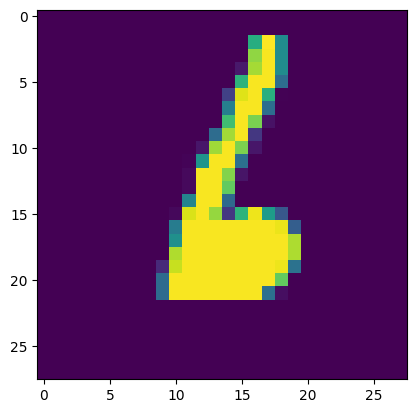

In [11]:
image_size = 28 # 28 x 28
number_row = 0
# the testing section is about 40% of the remaining data shuffled 
# forgot we actually transposed it before, so undo that by tranposing again
def plot(image_size, number_row, x_test, y_test, p):
    pixel_array = x_test.T[number_row] # pixel column as 1d array for the row chosen
    pixel_matrix = pixel_array.reshape(image_size, image_size) #reshape into 28 x 28 matrix
    print(f"Predicted: {p}, Actual: {y_test[number_row]}") # muah f strings 
    plt.imshow(pixel_matrix) # this is an image of the actual value 

plot(image_size, number_row, x_test, y_test, p)

Lets do a few more to see what the first 5 predictions look like 

Predicted: 6, Actual: 5


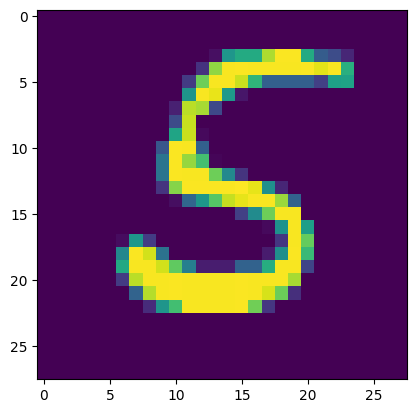

In [12]:
p = get_single_prediction(W1, b1, W2, b2, x_test, 1)
plot(image_size, 1, x_test, y_test, p)

Predicted: 3, Actual: 5


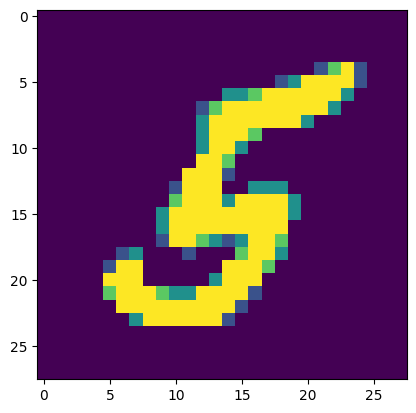

In [13]:
p = get_single_prediction(W1, b1, W2, b2, x_test, 2)
plot(image_size, 2, x_test, y_test, p)

Predicted: 3, Actual: 3


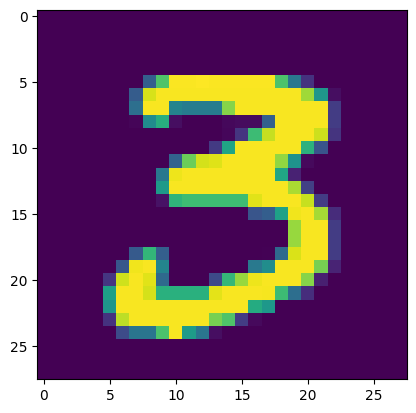

In [14]:
p = get_single_prediction(W1, b1, W2, b2, x_test, 3)
plot(image_size, 3, x_test, y_test, p)

Predicted: 2, Actual: 2


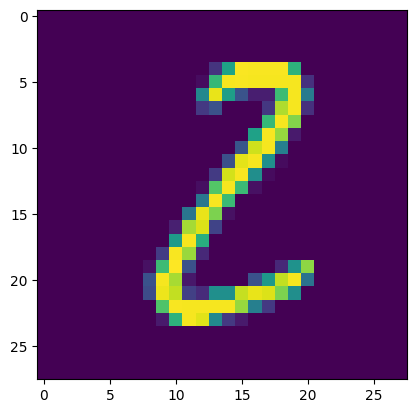

In [15]:
p = get_single_prediction(W1, b1, W2, b2, x_test, 4)
plot(image_size, 4, x_test, y_test, p)

Predicted: 4, Actual: 4


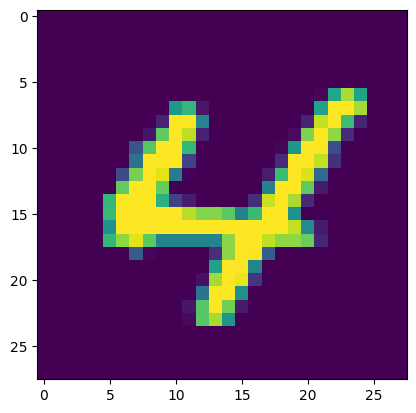

In [16]:
p = get_single_prediction(W1, b1, W2, b2, x_test, 5)
plot(image_size, 5, x_test, y_test, p)

# Conclusion and Acknowledgements: 

Trying our model on the entire testing data:



In [17]:
_,_,_, A2 = forward_propagation(W1, b1, W2, b2, x_test)
predictions = get_predictions(A2)
accuracy(predictions, y_test)

[6 6 3 ... 2 1 3] [6 5 5 ... 2 1 3]


0.8397619047619047

84% accuracy, so the model works pretty well with unseen data.

For the derivations of the partial derivatives with respect to the matricies here are some of the videos I watched:
1. [Samson Zhang](https://www.youtube.com/watch?v=w8yWXqWQYmU)
2. [Derivation of dz, db and dz](https://youtu.be/f-nW8cSa_Ec?si=3zQW1QK-63bRiUC7)
3. [derivation of the derivative of the softmax function](https://youtu.be/URJ9pP1aURo)
4. [3b1b's neural network playlist for singular nodes](https://www.youtube.com/watch?v=tIeHLnjs5U8&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&index=4)